In [1]:
%%capture
!pip install --upgrade einops optax equinox distrax jaxopt

In [2]:
from jax import numpy as jnp
from jax import random, value_and_grad, lax
from optax import adam, sgd, apply_updates, chain, clip, softmax_cross_entropy_with_integer_labels
from einops import rearrange, reduce, repeat
from functools import partial
from tqdm.notebook import tqdm
import equinox as eqx
import tensorflow_datasets as tfds
import tensorflow as tf
from jax.random import split, normal, randint
from jax import lax, vmap, checkpoint
from distrax import Normal, Bernoulli
from jax.nn import gelu, sigmoid, relu
from jax import disable_jit
from jaxopt import FixedPointIteration
from jax.tree_util import tree_map

import numpy as np
import jax

# Typing 
from jax import Array
from typing import Optional, Sequence, Tuple, Any
from jax.random import PRNGKeyArray

SEED = 0
MODEL_KEY = random.PRNGKey(SEED)
TEST_KEY = random.PRNGKey(SEED + 1)

import copy

In [3]:
def batch_loss(model, x_arr: Array, labels: Array) -> Array:
    '''Compute the loss.'''

    def loss(x: Array, label: Array):
        # -> (model(x)-Asin(x+w))^2
        pred = model(jnp.array([x]))
        return (pred-label)**2

    # Mean over the batch
    return vmap(loss)(x_arr, labels).mean()

In [4]:
def get_batch_of_tasks(N: int, key: PRNGKeyArray):
    # batch of size N
    # a task is given by amplitute A and phase w 
    A_key, w_key = split(key)
    A = random.uniform(A_key, shape=(N,),minval=0.1, maxval=5.0)
    w = random.uniform(w_key, shape=(N,),minval=0.0, maxval=jnp.pi)
    return A,w

In [5]:
def sample_from_task(A: float, w: float, N: int, key: PRNGKeyArray):
    # sample N examples from task
    # -> training data: train, train_labels both of size N

    # Task T(A,w): A in [0.1, 5.0], w in [0, pi]

    # Load the dataset

    train = random.uniform(key,minval=-5.0, maxval=5.0,shape=(N,))
    train_labels = A*jnp.sin(train+w)
    return train, train_labels 

In [6]:
# Training step function
#@eqx.filter_jit
def step(model, optimizer, opt_state, x_arr, labels):
    loss, grad = eqx.filter_value_and_grad(batch_loss)(model, x_arr, labels)  # Compute loss and gradient
    updates, opt_state = optimizer.update(grad, opt_state, model)  
    model = eqx.apply_updates(model, updates)  
    return model, opt_state, loss

In [7]:
epochs = 10000
model = eqx.nn.MLP(1,1,64,2,key=MODEL_KEY)
epsilon = 0.01  # outer loop LR, constant

In [8]:
K = 32

inner_optim = adam(1e-3, eps=1e-04)
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

@eqx.filter_jit
def maml_step(model, inner_opt_state, key: PRNGKeyArray):
    # Sample tasks for task(list)
    A, w = get_batch_of_tasks(1, key)
    train_key, val_key = split(key)
    train, train_labels = sample_from_task(A, w, K, train_key)  # get train_i and train_labels_i
    model_tilde = copy.deepcopy(model)
    for j in range(K):  # K steps of SGD or ADAM
        model_tilde, inner_opt_state, loss = step(model_tilde, inner_optim, inner_opt_state, train, train_labels)
    model = tree_map(lambda x,y: x+epsilon*(y-x) if type(x)==jax._src.interpreters.partial_eval.DynamicJaxprTracer else x, model, model_tilde)

    return loss, model, inner_opt_state

In [9]:
# Meta train the model
pbar = tqdm(random.split(MODEL_KEY,epochs),total=epochs)
for key in pbar:
    loss, model, inner_opt_state = maml_step(model, inner_opt_state, key)  # = filter_jit(step)(model, opt_state)
    pbar.set_postfix({'loss': f'{loss.mean():.3}'})

  0%|          | 0/10000 [00:00<?, ?it/s]

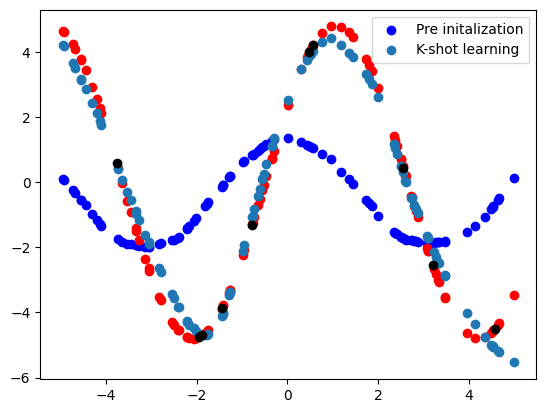

In [10]:
import matplotlib.pyplot as plt
test, test_labels = sample_from_task(jnp.array(4.8), jnp.array(0.5), 100, TEST_KEY)
train_test, train_test_labels = sample_from_task(jnp.array(4.8), jnp.array(0.5),10, TEST_KEY)
preds_initial = eqx.filter_vmap(model)(jnp.expand_dims(test,1))

plt.scatter(test, preds_initial, color='blue', label="Pre initalization")
plt.scatter(test, test_labels, color='red')

inner_optim = adam(1e-3, eps=1e-04)
#inner_optim = sgd(1)  # LR = 1 since the 'real' learning rate is included in alpha
inner_opt_state = inner_optim.init(eqx.filter(model, eqx.is_array))

trainable_model = copy.deepcopy(model)
for i in range(32):
    loss, grad = eqx.filter_value_and_grad(batch_loss)(trainable_model, train_test, train_test_labels)  # Compute loss and gradient
    updates, inner_opt_state = inner_optim.update(grad, inner_opt_state, trainable_model) 
    trainable_model = eqx.apply_updates(trainable_model, updates) 

preds_shot = eqx.filter_vmap(trainable_model)(jnp.expand_dims(test,1))
plt.scatter(test, preds_shot, label="K-shot learning")
plt.scatter(train_test, train_test_labels, color='black')
plt.legend()
plt.show()